In [1]:
run '../__init__.py'

In [2]:
import numpy as np
import networkx as nx
import cvxpy as cp

# import warnings
# warnings.filterwarnings("ignore")

(CVXPY) Sep 06 10:49:43 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/kimsha/anaconda3/envs/spec/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <EA245032-41C7-30EA-BA1A-C55492696949> /Users/kimsha/anaconda3/envs/spec/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so\n  Reason: tried: '/Users/kimsha/anaconda3/envs/spec/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/spec/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/spec/bin/../lib/liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/spec/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


## Networkx Tutorial

In [29]:
G = nx.Graph()

In [30]:
G.add_node(1)

In [31]:
G.add_nodes_from([2, 3])

In [32]:
G.add_nodes_from([
    (4, {"color": "red"}),
    (5, {"color": "green"})
])

In [33]:
H = nx.path_graph(10)

In [34]:
G.add_nodes_from(H)

In [35]:
G.add_edge(1, 2)
e = (2, 3)
G.add_edge(*e)

In [36]:
G.add_edges_from([
    (1, 2),
    (2, 3)
])

In [37]:
G.add_edges_from(H.edges)

In [38]:
G.clear()

In [39]:
G.add_edges_from([(1, 2), (1, 3)])
G.add_node(1)
G.add_edge(1, 2)
G.add_node("spam")        # adds node "spam"
G.add_nodes_from("spam")  # adds 4 nodes: 's', 'p', 'a', 'm'
G.add_edge(3, 'm')

In [40]:
G.number_of_nodes()

8

In [41]:
G.number_of_edges()

3

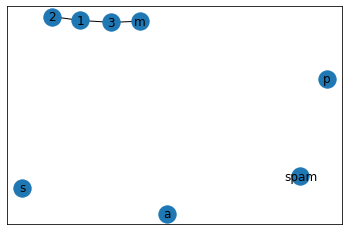

In [42]:
nx.draw_networkx(G)

### Edge Betweenness

In [43]:
G = nx.Graph()

In [44]:
G.add_nodes_from(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])

In [45]:
edges = [('C', 'B'), ('C', 'F'), ('B', 'F'), ('C', 'A'), ('B', 'A'),
         ('F', 'I'), ('I', 'K'), ('K', 'J'), ('J', 'G'), ('G', 'I'),
         ('A', 'E'), ('A', 'D'), ('E', 'H'), ('H', 'J'), ('D', 'H'),
         ('D', 'G')]
for e in edges:
    G.add_edge(*e)

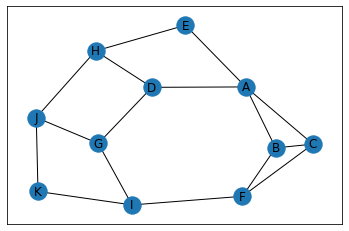

In [46]:
nx.draw_networkx(G)

In [26]:
nx.edge_betweenness(G, normalized=False)

{('A', 'C'): 7.385714285714284,
 ('A', 'B'): 7.385714285714284,
 ('A', 'E'): 8.01904761904762,
 ('A', 'D'): 10.752380952380953,
 ('B', 'C'): 1.0,
 ('B', 'F'): 6.185714285714286,
 ('C', 'F'): 6.185714285714286,
 ('D', 'H'): 6.495238095238095,
 ('D', 'G'): 8.876190476190477,
 ('E', 'H'): 7.352380952380952,
 ('F', 'I'): 11.895238095238096,
 ('G', 'J'): 6.109523809523809,
 ('G', 'I'): 8.519047619047619,
 ('H', 'J'): 8.752380952380951,
 ('I', 'K'): 7.376190476190477,
 ('J', 'K'): 6.7095238095238106}

## CVXPY

In [62]:
n = 3
known_value_indices = tuple(zip(*[[0, 0], [0, 2], [1, 1], [2, 0], [2, 1]]))
known_values = [1.0, 1.9, 0.8, 3.2, 5.9]
X = cp.Variable((n, n), pos=True)

In [63]:
objective_fn = cp.pf_eigenvalue(X)
constraints = [
  X[known_value_indices] == known_values,
  X[0, 1] * X[1, 0] * X[1, 2] * X[2, 2] == 1.0,
]

In [64]:
problem = cp.Problem(cp.Minimize(objective_fn), constraints)
print("X:\n", X.value)

X:
 None


In [65]:
problem.solve(gp=True)
print("Optimal value: ", problem.value)
print("X:\n", X.value)

Optimal value:  4.702374203221535
X:
 [[1.         4.63616907 1.9       ]
 [0.49991744 0.8        0.37774148]
 [3.2        5.9        1.14221476]]


In [5]:
def nuclear_norm_approximation(X, W, lam):
    m, n = X.shape
    Z = cp.Variable((m, n))
    objective = cp.norm(cp.multiply(W, (X - Z)), 'fro')**2 + lam * cp.norm(Z, 'nuc')
    problem = cp.Problem(cp.Minimize(objective))
    problem.solve()
    return Z.value

def alternating_optimization(F, Fbar, W, Wbar, lam, max_iter=100, tol=1e-6):
    F_c = np.copy(F)
    Fbar_c = np.copy(Fbar)
    for _ in range(max_iter):
        # Update F_c
        F_c_prev = np.copy(F_c)
        F_c = nuclear_norm_approximation(F, W, lam)
        
        # Update Fbar_c
        Fbar_c_prev = np.copy(Fbar_c)
        Fbar_c = nuclear_norm_approximation(Fbar, Wbar, lam)
        
        # Check convergence
        if np.linalg.norm(F_c - F_c_prev, 'fro') < tol and np.linalg.norm(Fbar_c - Fbar_c_prev, 'fro') < tol:
            break
    return F_c, Fbar_c

# Example data
F = np.array([[1, np.nan, 3], [np.nan, 5, 6], [7, 8, np.nan]])
Fbar = np.array([[1, 2, np.nan], [4, np.nan, 6], [7, 8, 9]])

# Create the binary matrices W and Wbar
W = np.isnan(F)
Wbar = np.isnan(Fbar)

# Parameters for the optimization
lam = 1e-3
max_iter = 100
tol = 1e-6

# Solve the problem
F_c, Fbar_c = alternating_optimization(F, Fbar, W, Wbar, lam, max_iter, tol)

# Compute the net parking state matrix P
P = Fbar_c - F_c


In [18]:
F

array([[ 1., nan,  3.],
       [nan,  5.,  6.],
       [ 7.,  8., nan]])

In [19]:
Fbar

array([[ 1.,  2., nan],
       [ 4., nan,  6.],
       [ 7.,  8.,  9.]])

In [10]:
import numpy as np
import cvxpy as cp

def nuclear_norm_approximation(X, W, lam, trace_ub):
    m, n = X.shape
    Z = cp.Variable((m, n))
    objective = cp.norm(cp.multiply(W, (X - Z)), 'fro')**2 + lam * cp.norm(Z, 'nuc')
    constraints = [cp.trace(Z) <= trace_ub]
    problem = cp.Problem(cp.Minimize(objective), constraints)
    problem.solve()
    return Z.value

def alternating_optimization(F, Fbar, W, Wbar, lam, trace_ub, max_iter=100, tol=1e-6):
    F_c = np.copy(F)
    Fbar_c = np.copy(Fbar)
    for _ in range(max_iter):
        # Update F_c
        F_c_prev = np.copy(F_c)
        F_c = nuclear_norm_approximation(F, W, lam, trace_ub)
        
        # Update Fbar_c
        Fbar_c_prev = np.copy(Fbar_c)
        Fbar_c = nuclear_norm_approximation(Fbar, Wbar, lam, trace_ub)
        
        # Check convergence
        if np.linalg.norm(F_c - F_c_prev, 'fro') < tol and np.linalg.norm(Fbar_c - Fbar_c_prev, 'fro') < tol:
            break
    return F_c, Fbar_c

# Example data
F = np.array([[1, np.nan, 3], [np.nan, 5, 6], [7, 8, np.nan]])
Fbar = np.array([[1, 2, np.nan], [4, np.nan, 6], [7, 8, 9]])

# Create the binary matrices W and Wbar
W = np.isnan(F)
Wbar = np.isnan(Fbar)

# Parameters for the optimization
lam = 1e-3
trace_ub = 10000000  # Adjust this value as needed
max_iter = 100
tol = 1e-6

# Solve the problem
F_c, Fbar_c = alternating_optimization(F, Fbar, W, Wbar, lam, trace_ub, max_iter, tol)

# Compute the net parking state matrix P
P = Fbar_c - F_c


WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK syev error, info = 5
WARN: LAPACK s


KeyboardInterrupt

